In [23]:
import os
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) # Set default figure size

In [2]:
# Open the file as readonly
h5f = h5py.File('SVHN_ready.h5', 'r')

# Load the training, test and validation set
X_trx_gray = h5f['X_trx_gray'][:]
X_te_gray = h5f['X_te_gray'][:]
tr_im = h5f['tr_im'][:]
y_trx_oh = h5f['y_trx_oh'][:]
te_im = h5f['te_im'][:]
y_te_oh = h5f['y_te_oh'][:]
# Close this file
h5f.close()

print('Training set', tr_im.shape, y_trx_oh.shape)
print('Test set', te_im.shape, y_te_oh.shape)

Training set (100000, 32, 32, 1) (100000, 10)
Test set (10000, 32, 32, 1) (10000, 10)


In [3]:
#Define a tensor as placeholders to feed values later
x = tf.placeholder(tf.float32, [None, 32, 32, 1])
y_ = tf.placeholder(tf.float32, [None,10])
y_cls = tf.argmax(y_, 1)


In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def fc_weight_variable(shape):
    n_in=8*8*64
    initial = tf.truncated_normal(shape, stddev=1/math.sqrt(n_in))
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


In [5]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

## First Convolutional Layer

In [6]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [7]:
x_image = tf.reshape(x, [-1,32,32,1])

In [8]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolutional Layer

In [9]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

In [10]:
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Dense layer

In [11]:
W_fc1 = fc_weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Dropout layer

In [12]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, rate = 1 - keep_prob)

In [13]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

## Training

In [14]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
def get_batch(img, lbl, batch_size):
    for i in np.arange(0, lbl.shape[0], batch_size):
        end = min(img.shape[0], i + batch_size)
        yield(img[i:end],lbl[i:end])

In [16]:
#train the neural network , run 500 epochs
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_loss = []
for i in range(5):
    step = 0   
    for (epoch_x , epoch_y) in get_batch(tr_im, y_trx_oh, 216):
        _, train_accu, c = sess.run([train_step, accuracy, cross_entropy], feed_dict={x: epoch_x, y_: epoch_y, keep_prob: 0.4})
        train_loss.append(c) 
        if(step%150 == 0):
            print ("Step:", step, ".....", "\nMini-Batch Loss   : ", c)
            print('Mini-Batch Accuracy :' , train_accu*100.0, '%')
        step = step + 1       

Step: 0 ..... 
Mini-Batch Loss   :  2.8637638
Mini-Batch Accuracy : 12.037037312984467 %
Step: 150 ..... 
Mini-Batch Loss   :  1.3110399
Mini-Batch Accuracy : 55.55555820465088 %
Step: 300 ..... 
Mini-Batch Loss   :  0.514483
Mini-Batch Accuracy : 84.72222089767456 %
Step: 450 ..... 
Mini-Batch Loss   :  0.3130799
Mini-Batch Accuracy : 90.27777910232544 %
Step: 0 ..... 
Mini-Batch Loss   :  0.67816234
Mini-Batch Accuracy : 80.55555820465088 %
Step: 150 ..... 
Mini-Batch Loss   :  0.5594757
Mini-Batch Accuracy : 83.79629850387573 %
Step: 300 ..... 
Mini-Batch Loss   :  0.3066916
Mini-Batch Accuracy : 90.74074029922485 %
Step: 450 ..... 
Mini-Batch Loss   :  0.20333894
Mini-Batch Accuracy : 95.37037014961243 %
Step: 0 ..... 
Mini-Batch Loss   :  0.52014196
Mini-Batch Accuracy : 85.64814925193787 %
Step: 150 ..... 
Mini-Batch Loss   :  0.42366627
Mini-Batch Accuracy : 87.03703880310059 %
Step: 300 ..... 
Mini-Batch Loss   :  0.23503278
Mini-Batch Accuracy : 93.05555820465088 %
Step: 450 .

In [17]:
test_accu= sess.run(accuracy, feed_dict={x: te_im, y_: y_te_oh, keep_prob: 1})

print('testing accuracy :' , test_accu*100.0, '%')

testing accuracy : 89.60999846458435 %


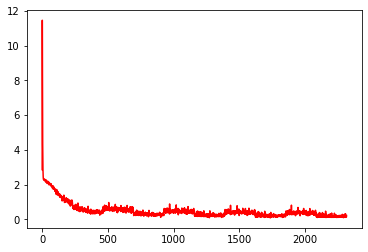

In [18]:
plt.plot(train_loss ,'r')

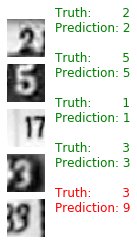

In [19]:
#To evaluate the model, Pick 5 random images from test dataset
sample_indexes = [0,700,2490,7000,9]
sample_images = [te_im[i] for i in sample_indexes]
sample_labels = [y_te_oh[i] for i in sample_indexes]
#predict the label, feed the sample images
pred = sess.run(tf.argmax(y_conv, 1), feed_dict={x: sample_images,keep_prob: 1})
predicted=np.squeeze(pred)                     

# Display the predictions and the actual label.
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5,1,1+i)
    plt.axis('off')
    color='green' if np.argmax(truth) == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(np.argmax(truth), prediction), 
             fontsize=12, color=color)
    plt.imshow(X_te_gray[sample_indexes[i]],  cmap="gray")

plt.show()

In [21]:
pred = sess.run(tf.argmax(y_conv, 1), feed_dict={x: te_im,keep_prob: 1})
print(pred)
print(np.argmax(y_te_oh,1))

[2 1 0 ... 7 9 1]
[2 1 0 ... 7 9 9]


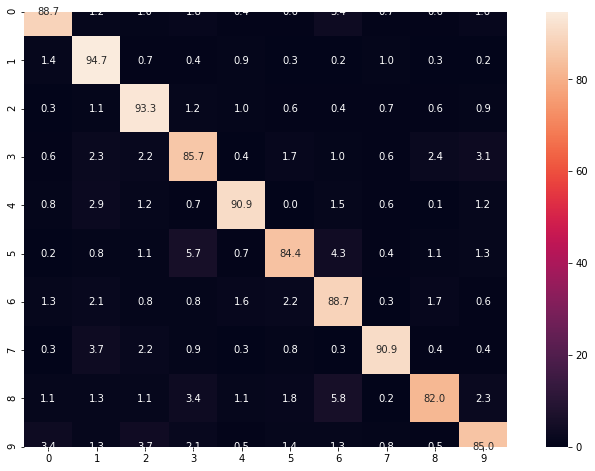

In [50]:

plt.figure(figsize=(14, 8))
cm=confusion_matrix(np.argmax(y_te_oh,1), pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
sns.heatmap(cm, annot=True, fmt='.1f', square=True);